In [1]:
import numpy as np
import pandas as pd
import re

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections 

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import namedtuple
from scipy import spatial

# modeling

### 데이터셋 불러오기

In [63]:
final_list  = pd.read_excel('C:/Users/hangy/Desktop/topics/data/final_list_score.xlsx')
invest_info = pd.read_excel('C:/Users/hangy/Desktop/topics/data/middle_node_list.xlsx')
small_info  = pd.read_excel('C:/Users/hangy/Desktop/topics/data/small_node_info.xlsx')
middle_info = pd.read_excel('C:/Users/hangy/Desktop/topics/data/middle_info.xlsx')
prime_info  = pd.read_excel('C:/Users/hangy/Desktop/topics/data/prime_info.xlsx')

In [64]:
final_list = final_list[final_list['establish']<=6]

In [65]:
middle_info = middle_info.fillna(0)
middle_info = middle_info.append(prime_info,ignore_index=True, sort=True)

In [66]:
final_list = pd.merge(final_list,middle_info,how='left')

In [67]:
final_list = final_list[final_list['status']=='정상'].reset_index(drop=True)

In [68]:
middle = final_list[(final_list['establish'] <= 6) & (final_list['establish'] >= 4)].reset_index(drop=True)
prime  = final_list[final_list['establish'] < 4].reset_index(drop=True)

In [69]:
middle['invest'] = [str(x).split(',') for x in middle['invest']]

### 네트워크

In [70]:
def network_score(G) :
    tt =  { "degree":dict(G.degree()), 
            "degree_centrality":nx.degree_centrality(G), #normalized degree, degree가 클수록 높음
            "closeness_centrality":nx.closeness_centrality(G), 
            "betweenness_centrality":nx.betweenness_centrality(G), 
            "pagerank":nx.pagerank(G)}
    tt_df = pd.DataFrame(tt)
    tt_df['node'] = list(tt_df.index)
    tt_df = pd.merge(tt_df,node_df,how='left')
    tt_df = pd.merge(tt_df,pd.DataFrame(weight_list,columns=['node','i_weight']),how='left')
    tt_df = pd.merge(tt_df,pd.DataFrame(s_weight_list,columns=['node','s_weight']),how='left')
    return tt_df

In [71]:
company = list(middle['company'])
company_idx = ["c%d" % i for i in range(1,len(company)+1)]
node_df = pd.DataFrame({'node':company,'node_idx':company_idx})

In [72]:
invest = list(middle['invest'])
temp = []
for i in range(len(invest)):
    temp  = temp + invest[i]

In [73]:
invest = list(set(temp))
invest_idx = ["i%d" % i for i in range(1,len(invest)+1)]

In [74]:
invest_node = pd.DataFrame({'node':invest,'node_idx':invest_idx})
node_df = node_df.append(pd.DataFrame(data=invest_node),ignore_index=True)

In [75]:
invest_info = pd.merge(invest_node,invest_info,how='left')
invest_info = invest_info[~(invest_info['inv_num'].isnull())].reset_index(drop=True)

In [76]:
invest_info['normal_num']=[(x/sum(invest_info['inv_num']))*100 for x in invest_info['inv_num']]
invest_info['normal_total']=[(x/sum(invest_info['inv_total']))*100 for x in invest_info['inv_total']]
invest_info['inv_weight'] = invest_info['normal_total']+ invest_info['normal_num']

In [77]:
edge = []
weigth_edge = []
weight_list = []
for i in range(len(middle)):
    weight_sum = 0 
    for j in range(len(middle['invest'][i])):
        if middle['invest'][i][j] != 'nan':
            company = middle['company'][i]
            invest = middle['invest'][i][j]
            weight = list(invest_info[invest_info['node']== invest]['inv_weight'])[0]
            weight_sum = weight_sum + weight
            edge.append((invest,company))
            weigth_edge.append((invest,company,{'weight':weight}))
            #edge.append((company,invest,{'weight':weight}))
    weight_list.append((middle['company'][i],weight_sum))

In [78]:
small = list(set(list(middle['predicted_label1']) + list(middle['predicted_label2'])))
small_idx = ["s%d" % i for i in range(1,len(small)+1)]

In [79]:
small_node = pd.DataFrame({'node':small,'node_idx':small_idx})
node_df = node_df.append(pd.DataFrame(data=small_node),ignore_index=True)

In [80]:
temp = pd.DataFrame({'new_small_class':small,'node_idx':small_idx})
small_node_info = pd.merge(temp,small_info,how='left')

In [81]:
temp = pd.DataFrame({'new_small_class':small,'node_idx':small_idx})
small_node_info = pd.merge(temp,small_info,how='left')
small_node_info = small_node_info[['new_small_class','node_idx','세계시장_20','국내시장_20','특허']].copy()
small_node_info.columns = ['node','node_idx','global','national','patent']

In [82]:
small_node_info = small_node_info.fillna(0)

In [83]:
small_node_info['normal_global']=[(x/sum(small_node_info['global']))*100 for x in small_node_info['global']]
small_node_info['normal_total']=[(x/sum(small_node_info['national']))*100 for x in small_node_info['national']]
small_node_info['normal_patent']=[(x/sum(small_node_info['patent']))*100 for x in small_node_info['patent']]
small_node_info['small_weight'] = small_node_info['normal_global']+ small_node_info['normal_total'] + small_node_info['normal_patent']

In [84]:
s_edge = []
s_weight_edge = []
s_weight_list = []
for i in range(len(middle)):
    company = middle['company'][i]
    small1 = middle['predicted_label1'][i]
    small2 = middle['predicted_label2'][i]
    weight1 = list(small_node_info[small_node_info['node']== small1]['small_weight'])[0]
    weight2 = list(small_node_info[small_node_info['node']== small2]['small_weight'])[0]
    weight_sum = weight1 + weight2
    s_weight_list.append((company,weight_sum))
    s_weight_edge.append((small1,company,{'weight':weight1}))
    s_weight_edge.append((small2,company,{'weight':weight2}))
    s_edge.append((small1,company))
    s_edge.append((small2,company))

In [85]:
weight_direct_G = nx.DiGraph()
weight_nondirect_G = nx.Graph()
nondirect_G = nx.Graph()

In [86]:
weight_direct_G.add_edges_from(weigth_edge+s_weight_edge)
weight_nondirect_G.add_edges_from(weigth_edge+s_weight_edge)
nondirect_G.add_edges_from(edge+s_edge)

In [87]:
weight_direct_score = network_score(weight_direct_G)
weight_nondirect_score = network_score(weight_nondirect_G)
nondirect_score = network_score(nondirect_G)

In [88]:
network_result = weight_nondirect_score[weight_nondirect_score['node_idx'].isin(company_idx)].sort_values(["pagerank"], ascending=[False])

In [89]:
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

In [90]:
middle['normal_take']   = minmax_scale(middle['매출액'])
middle['normal_growth'] = minmax_scale(middle['매출액증가율(성장성)'])
middle['normal_profit'] = minmax_scale(middle['영업이익률(수익성)'])
middle['normal_patent'] = minmax_scale(middle['patent'])
middle['normal_total']  = minmax_scale(middle['total'])

In [91]:
middle['node'] = middle['company']

In [92]:
network_result = pd.merge(network_result,middle[['node','normal_take','normal_growth','normal_profit','normal_patent','normal_total','tips']])

In [93]:
network_result['normal_pagerank'] = minmax_scale(network_result['pagerank'])*6
network_result['total_weight'] = network_result.iloc[:,-7:].sum(axis=1)
network_result = network_result.sort_values(["total_weight"], ascending=[False]).reset_index(drop=True)

In [94]:
network_result

,degree,degree_centrality,closeness_centrality,betweenness_centrality,pagerank,node,node_idx,i_weight,s_weight,normal_take,normal_growth,normal_profit,normal_patent,normal_total,tips,normal_pagerank,total_weight
0,14,0.050542,0.279415,0.095448,0.013961,(주)뤼이드,c6,26.383121,8.218990,0.017324,0.024514,0.963289,0.666667,0.313629,1,6.000000,8.985422
1,8,0.028881,0.263138,0.065818,0.013082,(주)데이블,c8,26.655898,41.855258,0.073102,0.024151,0.995048,0.166667,0.303777,1,5.583990,8.146734
2,9,0.032491,0.232048,0.052004,0.013457,(주)제이엘케이인스펙션,c28,19.321385,12.353012,0.003105,0.019251,0.804295,0.916667,0.016420,0,5.761363,7.521101
3,10,0.036101,0.261110,0.051500,0.011673,다이닝코드,c4,17.506072,118.650152,0.000556,0.385244,0.741466,0.000000,0.080460,1,4.917726,7.125452
4,9,0.032491,0.243297,0.066810,0.010828,매드스퀘어(주),c9,16.819712,7.870010,0.001523,0.004461,0.994671,0.083333,0.052545,1,4.518121,6.654654
5,10,0.036101,0.223624,0.075403,0.012700,제노플랜,c39,14.591351,14.209840,0.004397,0.015464,0.955160,0.166667,0.095238,0,5.403411,6.640338
6,10,0.036101,0.269416,0.068942,0.010533,클래스101,c53,22.595130,7.304061,0.041474,0.078181,0.996473,0.000000,0.016420,1,4.378728,6.511277
7,7,0.025271,0.268349,0.044734,0.011913,가우디오랩,c36,32.443813,6.618364,0.000171,0.004461,0.000000,0.333333,0.027915,1,5.031525,6.397405
8,10,0.036101,0.277697,0.060617,0.007117,(주)시어스랩,c5,14.895417,4.241349,0.011061,0.006386,0.995072,1.000000,0.083744,1,2.763300,5.859565
9,10,0.036101,0.256174,0.072552,0.009337,주식회사 푸른밤,c40,12.153125,2.506845,0.001942,0.012982,0.908711,0.000000,0.110016,1,3.813254,5.846905


# recomendation

### 문서유사도

In [95]:
tips_data   = pd.read_excel('C:/Users/hangy/Desktop/topics/data/tips_data.xlsx')
startup_data = pd.read_excel('C:/Users/hangy/Desktop/topics/data/startup_data.xlsx')

In [96]:
dupli_list = list(set(tips_data['company']).intersection(set(startup_data['company']))) 
startup_data = startup_data[~(startup_data['company'].isin(dupli_list))].reset_index(drop=True)
token_df = tips_data[['company','token','lable']].append(startup_data[['company','token','lable']],ignore_index=True)

In [97]:
final_list = pd.merge(final_list,token_df,how='left')

In [98]:
# loading Doc2vec model
model_name = 'Doc2vec1.model'
doc_vectorizer = Doc2Vec.load(model_name)

In [99]:
final_list['token'] = final_list['token'].fillna('')

In [100]:
final_list['token'] = final_list['token'].apply(lambda x: x.replace("['","").replace("']","").split("', '"))

In [101]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_docs = [TaggedDocument(d, c) for d, c in final_list[['token', 'lable']].values]
X = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_docs]
y = [doc.tags for doc in tagged_docs]

In [102]:
similarity = []
for i in range(len(X)):
    temp = []
    for j in range(len(X)):
        temp.append(1 - spatial.distance.cosine(X[i], X[j]))
        y = np.array(temp)
    #similarity.append(y*temp)
    similarity.append(y)
similarity_edge = pd.DataFrame(np.matrix(similarity),columns=final_list['company'])

### 추천

In [103]:
def recommend(target):
    target_idx = final_list[final_list['company']==target].index[0]
    category1 = middle[middle['company']== target]['predicted_label1'].values[0]
    category2 = middle[middle['company']== target]['predicted_label2'].values[0]
    category  = [category1,category2]
    print('target :',target,' ,categroy :',category)
    ss = prime[(prime['predicted_label1'].isin(category))|(prime['predicted_label2'].isin(category))].reset_index(drop=True)
    
    similarity = []
    for i in range(len(ss)):
        temp = ss['company'][i]
        temp_idx = final_list[final_list['company']==temp].index[0]
        s_score = 1 - spatial.distance.cosine(X[target_idx], X[temp_idx])
        similarity.append(s_score)
    ss['similarity'] =similarity
    ss['normal_total']   = minmax_scale(ss['total'])
    ss['normal_similarity']   = minmax_scale(ss['similarity'])
    ss['normal_patent']   = minmax_scale(ss['patent'])
    
#     ss['normal_total']      = [(x/sum(ss['total']))*10 for x in ss['total']]
#     ss['normal_similarity'] = ss['similarity']
#     ss['normal_patent']     = [(x/sum(ss['patent']))*10 for x in ss['patent']]
    
    ss['weight'] = ss['normal_total']+ ss['normal_similarity'] + ss['tips'] + ss['normal_patent'] + ss['tips']
    recomend_result = ss.sort_values(["weight"], ascending=[False]).reset_index(drop=True)
    print('==============================================================================')
    print('recomend result top 5')
    print('==============================================================================')
    print(recomend_result[0:5][['company','weight']])
    return recomend_result

In [104]:
target = network_result['node'][0]
recomend_result = recommend(target)

target : (주)뤼이드  ,categroy : ['에듀테크 콘텐츠', '인공지능 플랫폼']
recomend result top 5
  company    weight
0   디자이노블  3.746225
1     페달링  3.527675
2      산타  3.503358
3    아토머스  3.383991
4  로지브라더스  3.326142


### 네트워크 그리키

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Input data files check
from subprocess import check_output

import warnings
warnings.filterwarnings('ignore')

In [48]:
weigth_edge = []
for i in range(len(middle)):
    weight_sum = 0 
    for j in range(len(middle['invest'][i])):
        if middle['invest'][i][j] != 'nan':
            company = middle['company'][i]
            invest = middle['invest'][i][j]
            weight = list(invest_info[invest_info['node']== invest]['inv_weight'])[0]
            weight_sum = weight_sum + weight
            company = node_df[node_df['node']==company]['node_idx'].values[0]
            invest = node_df[node_df['node']==invest]['node_idx'].values[0]
            weigth_edge.append((invest,company,weight))
            #edge.append((company,invest,{'weight':weight}))

In [49]:
s_weight_edge = []
for i in range(len(middle)):
    company = middle['company'][i]
    small1 = middle['predicted_label1'][i]
    small2 = middle['predicted_label2'][i]
    weight1 = list(small_node_info[small_node_info['node']== small1]['small_weight'])[0]
    weight2 = list(small_node_info[small_node_info['node']== small2]['small_weight'])[0]
    weight_sum = weight1 + weight2
    small1 = node_df[node_df['node']==small1]['node_idx'].values[0]
    small2 = node_df[node_df['node']==small2]['node_idx'].values[0]
    company = node_df[node_df['node']==company]['node_idx'].values[0]
    s_weight_edge.append((small1,company,weight1))
    s_weight_edge.append((small2,company,weight2))

In [50]:
s_weight_edge = pd.DataFrame(s_weight_edge,columns=['source','target','value'])
weigth_edge = pd.DataFrame(weigth_edge,columns=['source','target','value'])
df_edges = s_weight_edge.append(weigth_edge, ignore_index=True)

In [51]:
df_nodes = pd.DataFrame()
df_nodes['name'] = node_df['node_idx']

In [52]:
group = []
for i in range(len(df_nodes)):
    if df_nodes['name'][i][0] == 'c' :
        group.append(0)
    elif df_nodes['name'][i][0] == 's' :
        group.append(1)
    elif df_nodes['name'][i][0] == 'i' :
        group.append(2)     
        
df_nodes['group'] = group

In [53]:
a = weight_nondirect_score[['node_idx','pagerank']].copy()
a.columns = ['name','nodesize']
df_nodes = pd.merge(df_nodes,a,how = 'left')

In [54]:
temp = []
for i in range(len(df_nodes)):
    if df_nodes['group'][i] == 0:
        temp.append(df_nodes['nodesize'][i]*10000)
    else :
        temp.append(20)

In [55]:
df_nodes['nodesize'] = temp

In [56]:
df_nodes['nodesize'] = df_nodes['nodesize']*5

In [57]:
color_map = {0:'#ffdf55', 1:'#eebcbc', 2:'#72bbd0'}

In [58]:
classes = np.array(df_nodes['group'])
classnames, indices = np.unique(classes, return_inverse=True)

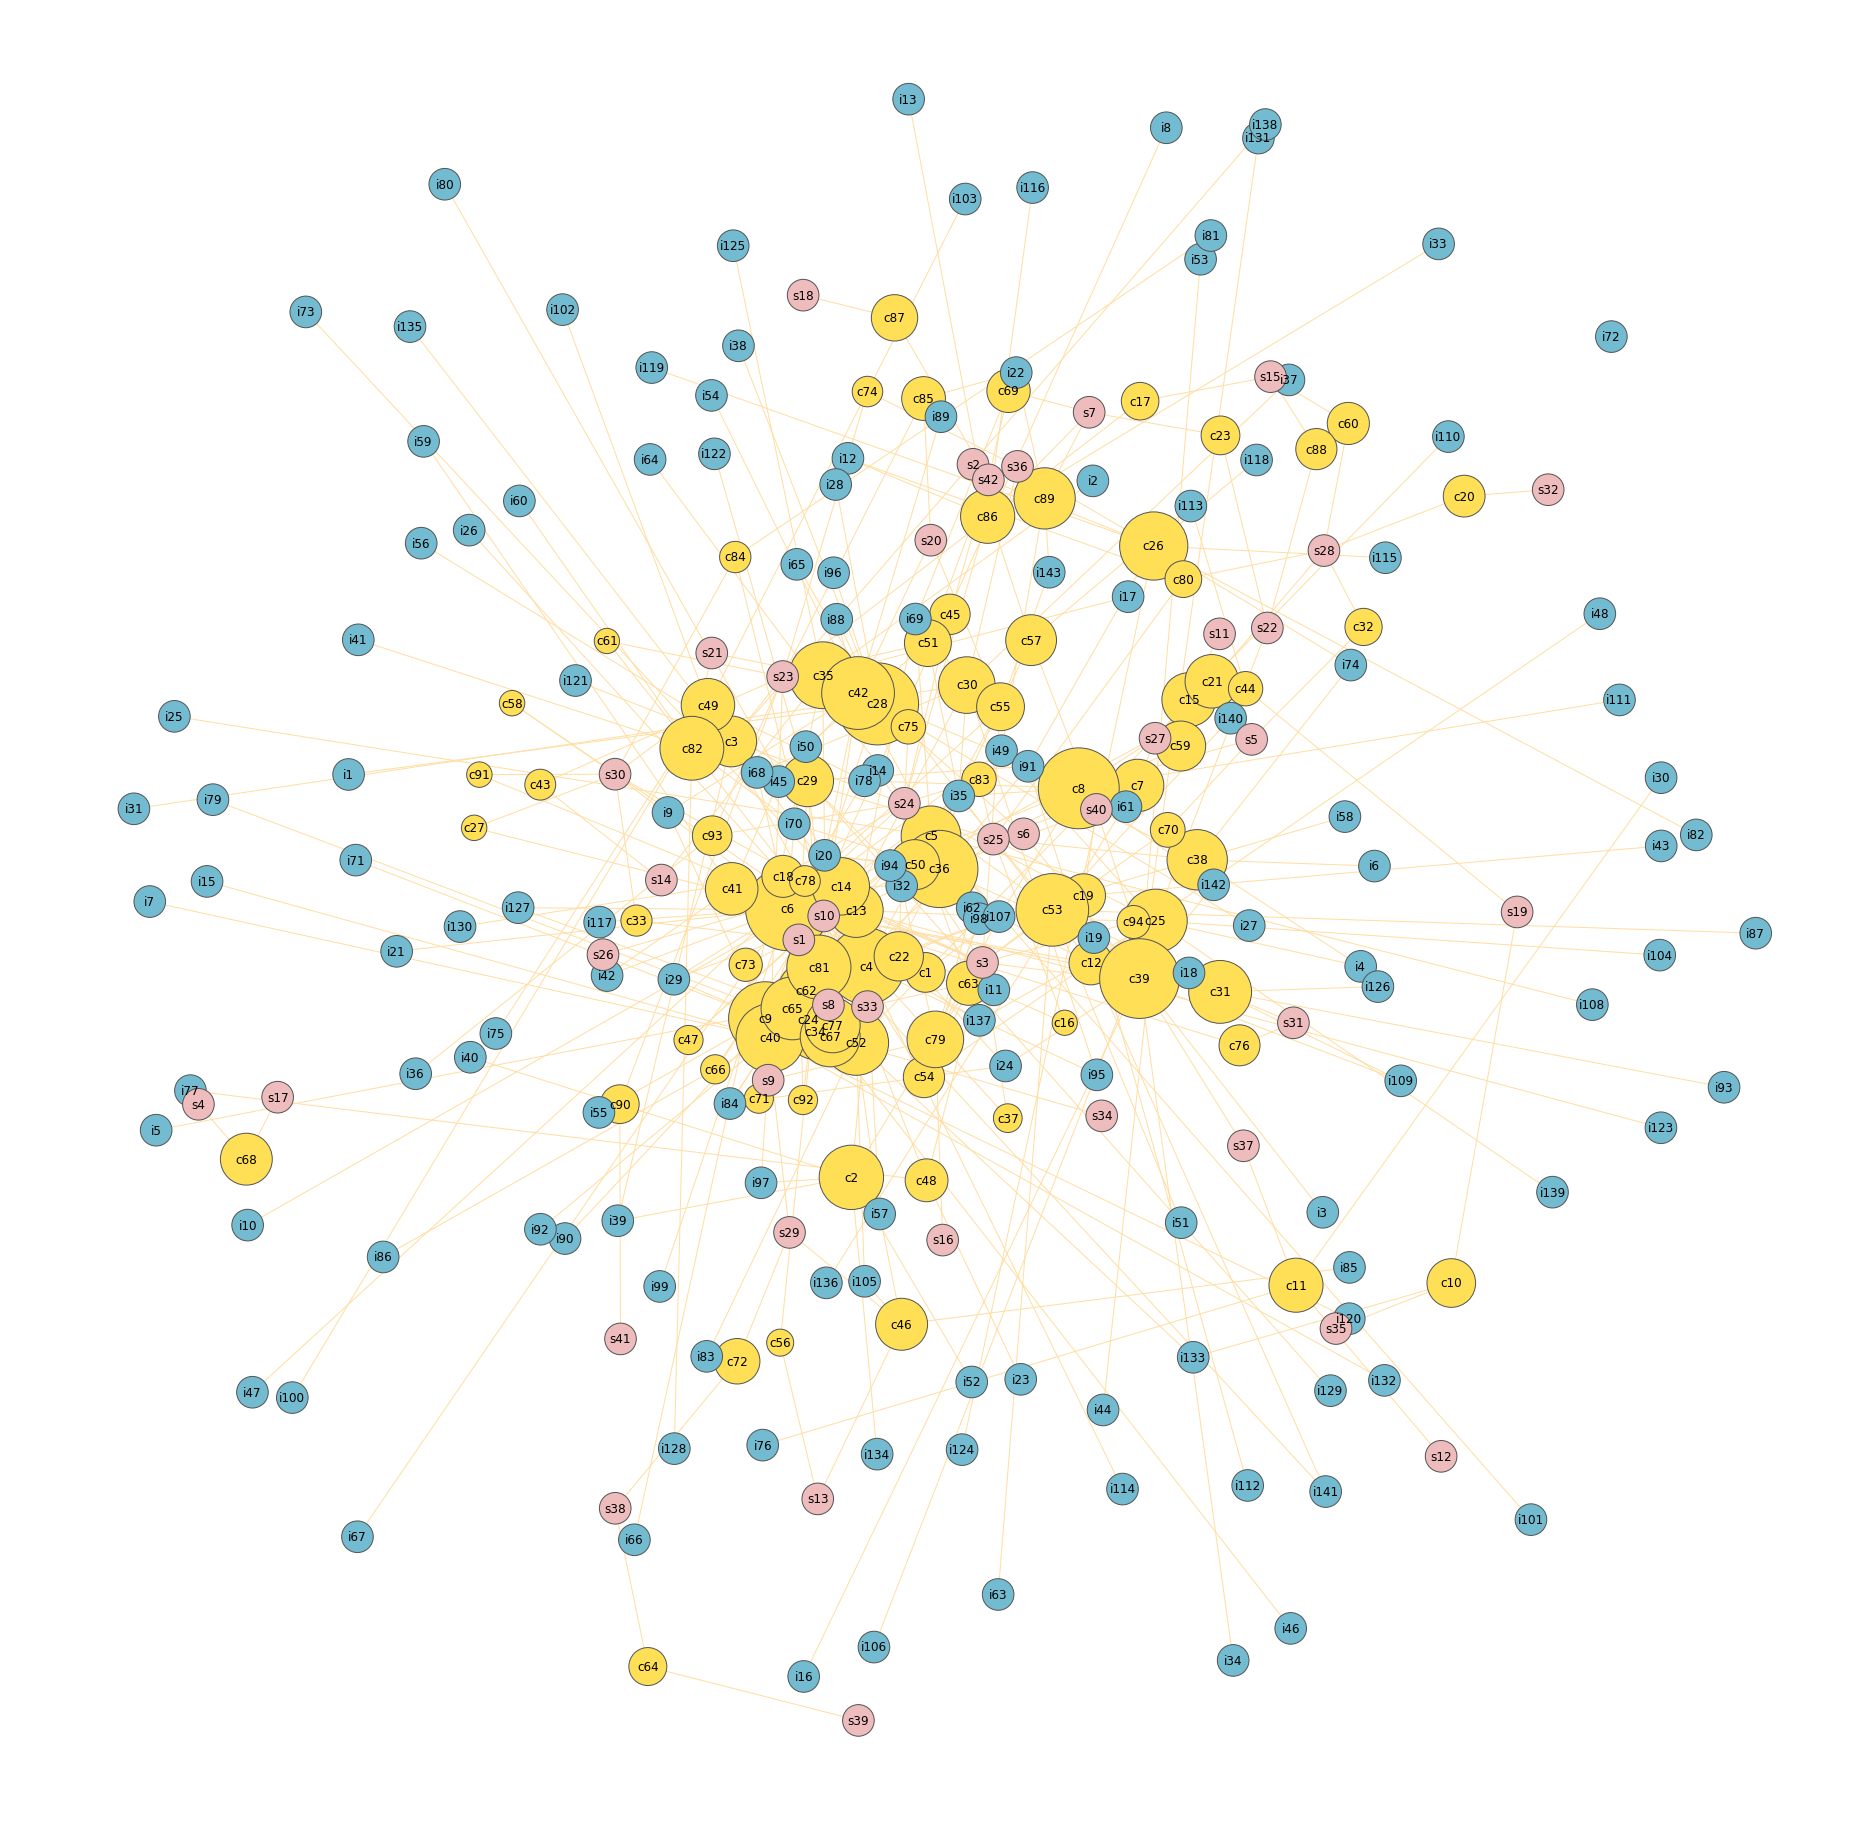

In [59]:
G = nx.Graph(day="Stackoverflow")


for index, row in df_nodes.iterrows():
    G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
    
for index, row in df_edges.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['value'])])
    
plt.figure(figsize=(25,25))
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}
colors = [color_map[G.node[node]['group']] for node in G]
sizes = [G.node[node]['nodesize']*10 for node in G]

nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.show()